In [1]:
import pickle
import numpy as np
# from skimage import io
import torch
import os
import cv2

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import datasets, models, transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from IPython.display import clear_output

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
DATA_MODES = ['train', 'val', 'test']
IMG_SIZE = 100
NUM_CLASSES = 10

In [3]:
TRAIN_DIR = Path('./train/train')
TEST_DIR = Path('./test/test')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.JPG')))
test_files = sorted(list(TEST_DIR.rglob('*.JPG')))

In [4]:
len(test_files)

105

In [5]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify=train_val_labels)

In [6]:
class XDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode
        self.len_ = len(self.files)     
        self.label_encoder = LabelEncoder()
        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomRotation(5),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((IMG_SIZE, IMG_SIZE))
        return np.array(image)

In [7]:
test_dataset = XDataset(test_files, mode="test")
val_dataset = XDataset(val_files, mode="val")
train_dataset = XDataset(train_files, mode="train")

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=64)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=64)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=16)

In [8]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

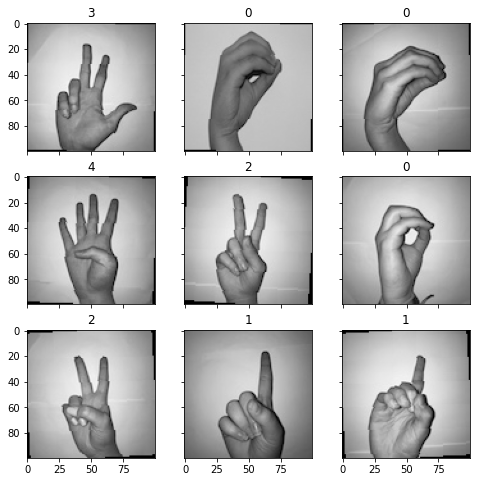

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,200))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [10]:
def train(train_loader, val_loader, model, optimaizer, loss_fn, epochs):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimaizer)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, loss_fn)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [11]:
def train_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)

        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [12]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [13]:
import torchvision.models as models

model = models.vgg11_bn(pretrained=False)

In [14]:
from torchinfo import summary

summary(model, input_size=(64, 3, 100, 100))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [64, 512, 3, 3]           --
│    └─Conv2d: 2-1                       [64, 64, 100, 100]        1,792
│    └─BatchNorm2d: 2-2                  [64, 64, 100, 100]        128
│    └─ReLU: 2-3                         [64, 64, 100, 100]        --
│    └─MaxPool2d: 2-4                    [64, 64, 50, 50]          --
│    └─Conv2d: 2-5                       [64, 128, 50, 50]         73,856
│    └─BatchNorm2d: 2-6                  [64, 128, 50, 50]         256
│    └─ReLU: 2-7                         [64, 128, 50, 50]         --
│    └─MaxPool2d: 2-8                    [64, 128, 25, 25]         --
│    └─Conv2d: 2-9                       [64, 256, 25, 25]         295,168
│    └─BatchNorm2d: 2-10                 [64, 256, 25, 25]         512
│    └─ReLU: 2-11                        [64, 256, 25, 25]         --


In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
#количество фичей на вход полносвязного слоя
num_features = 4096
#количество классов
n_classes = 10

# Заменяем Fully-Connected слой на наш линейный классификатор
model.classifier[6] = nn.Linear(num_features, n_classes)  


loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model = model.to(device)

In [17]:
history = train(train_loader, val_loader, model=model, optimaizer=optimizer, loss_fn=loss_fn, epochs=10)

epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

loss 2.293681091941292


epoch:  10%|███████▌                                                                    | 1/10 [00:16<02:30, 16.72s/it]


Epoch 001 train_loss: 2.2937     val_loss 2.2613 train_acc 0.1886 val_acc 0.1017
loss 1.7614238767496668


epoch:  20%|███████████████▏                                                            | 2/10 [00:29<01:56, 14.51s/it]


Epoch 002 train_loss: 1.7614     val_loss 1.2001 train_acc 0.4463 val_acc 0.5835
loss 0.7740529305722368


epoch:  30%|██████████████████████▊                                                     | 3/10 [00:42<01:36, 13.80s/it]


Epoch 003 train_loss: 0.7741     val_loss 0.5144 train_acc 0.7459 val_acc 0.8160
loss 0.44198373084794107


epoch:  40%|██████████████████████████████▍                                             | 4/10 [00:55<01:20, 13.47s/it]


Epoch 004 train_loss: 0.4420     val_loss 0.4713 train_acc 0.8478 val_acc 0.8378
loss 0.3210548684407611


epoch:  50%|██████████████████████████████████████                                      | 5/10 [01:08<01:06, 13.29s/it]


Epoch 005 train_loss: 0.3211     val_loss 0.3023 train_acc 0.8933 val_acc 0.8935
loss 0.20874567295544938


epoch:  60%|█████████████████████████████████████████████▌                              | 6/10 [01:21<00:52, 13.18s/it]


Epoch 006 train_loss: 0.2087     val_loss 0.2008 train_acc 0.9315 val_acc 0.9346
loss 0.15023397569803848


epoch:  70%|█████████████████████████████████████████████████████▏                      | 7/10 [01:34<00:39, 13.11s/it]


Epoch 007 train_loss: 0.1502     val_loss 0.1459 train_acc 0.9545 val_acc 0.9492
loss 0.09498147046551551


epoch:  80%|████████████████████████████████████████████████████████████▊               | 8/10 [01:47<00:26, 13.07s/it]


Epoch 008 train_loss: 0.0950     val_loss 0.1145 train_acc 0.9715 val_acc 0.9661
loss 0.07331594347664629


epoch:  90%|████████████████████████████████████████████████████████████████████▍       | 9/10 [02:00<00:13, 13.04s/it]


Epoch 009 train_loss: 0.0733     val_loss 0.1131 train_acc 0.9788 val_acc 0.9613
loss 0.04540408615321102


epoch: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [02:13<00:00, 13.34s/it]


Epoch 010 train_loss: 0.0454     val_loss 0.1176 train_acc 0.9885 val_acc 0.9540


In [18]:
def predict(model, test_loader):
    model.eval()
    with torch.no_grad():
        logits = []
        
        for inputs in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [19]:
probs = predict(model, test_loader)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))

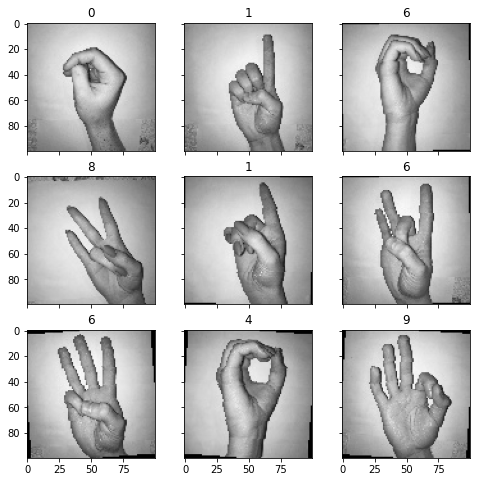

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,105))
    im_val, label = test_dataset[random_characters], probs
    img_label = " ".join(map(lambda x: x.capitalize(),\
                preds[random_characters].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [21]:
test_filenames = [path.name for path in test_dataset.files]


In [22]:
import pandas as pd
df = pd.DataFrame()
df['id'] = test_filenames
df['labels'] = preds
df.to_csv('sample_submition_grayscale.csv', index=False)

In [23]:
df

,id,labels
0,img0.JPG,0
1,img1.JPG,0
2,img10.JPG,1
3,img100.JPG,9
4,img101.JPG,9
...,...,...
100,img95.JPG,8
101,img96.JPG,8
102,img97.JPG,8
103,img98.JPG,6
